In [1]:
import pandas as pd 
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re

import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords

from wordcloud import WordCloud 

from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
import sklearn.metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import string

from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def rm_punct_symb(phrase):
    phrase_no_punct = "".join([i for i in phrase if i not in string.punctuation])
    return phrase_no_punct

# Data preparation

In [3]:
# Importazione dataset e riconversione colonna in lista di stringhe, come già fatto nel preprocessing

df = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_lemmatized.csv')
df['Lemmatized Text'] = df['Lemmatized Text'].apply(rm_punct_symb)
df['Lemmatized Text'] = df['Lemmatized Text'].str.split(' ')

In [4]:
# Mantengo solo le colonne necessarie al clustering

clust_df = df[['Lemmatized Text', 'Score']]

In [5]:
clust_df.head()

,Lemmatized Text,Score
0,"[bought, several, vitality, canned, dog, food,...",5
1,"[product, arrived, labelled, lumbo, halted, pe...",1
2,"[connection, around, century, light, pillow, c...",4
3,"[looking, secret, ingredient, robitussin, beli...",2
4,"[great, staff, great, price, wide, assortment,...",5


Sappiamo che le review sono sbilanciate verso la classe '4' e '5': procedo al downsampling.

Text(0, 0.5, 'Number of reviews')

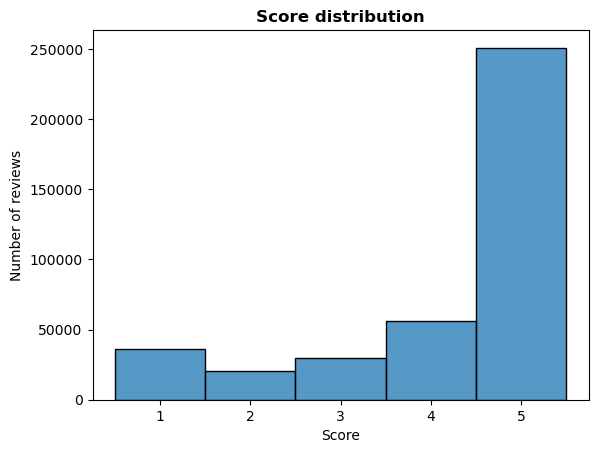

In [6]:
sns.histplot(clust_df['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [7]:
sample_size = clust_df.groupby('Score').count().min()[0] # Prendo come dimensione quella minima fra tutte le classi

df_downsampled = clust_df.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size))
df_downsampled

,Lemmatized Text,Score
251666,"[since, diagnosed, lumen, sensitivity, searchi...",1
316782,"[ordered, party, favor, sent, regular, olive, ...",1
323318,"[ok, like, stronger, wasting, sauce, definitel...",1
57702,"[like, coffee, particularly, ice, full, discla...",1
303301,"[palmar, cell, thats, approximately, bottle, p...",1
...,...,...
64465,"[right, amount, salt, taste, great, would, hes...",5
260189,"[love, jacob, coffee, got, hooked, living, ger...",5
254254,"[hand, say, biggest, moneysaving, expense, ive...",5
14942,"[first, give, careful, might, draw, back, sub,...",5


Text(0, 0.5, 'Number of reviews')

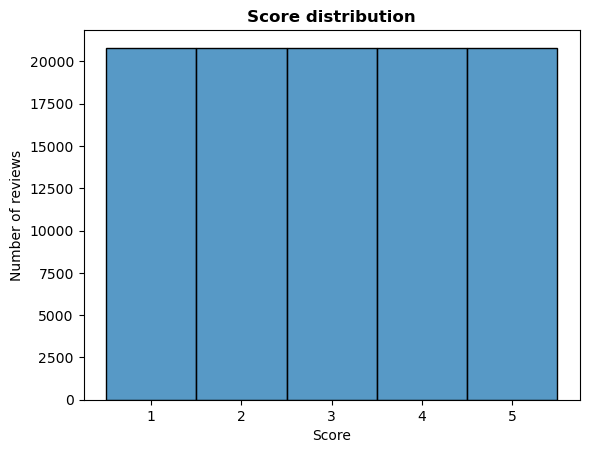

In [8]:
sns.histplot(df_downsampled['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [9]:
# Eseguo uno shuffle dei dati

df_4_clustering = shuffle(df_downsampled, random_state = 123)
df_4_clustering.reset_index(drop=True, inplace=True)
df_4_clustering.head()

,Lemmatized Text,Score
0,"[pushkin, spice, flavor, worst, pushkin, spice...",1
1,"[anxious, eat, gumma, candle, couple, bite, me...",2
2,"[far, best, lumen, free, penza, ive, organic, ...",5
3,"[ive, using, stuff, around, week, havent, seen...",4
4,"[like, know, product, used, many, year, wish, ...",2


In [10]:
# Divido x e y

x_clust = df_4_clustering['Lemmatized Text']
y_clust = df_4_clustering['Score']

# Clustering

## BOW

In [11]:
cv = CountVectorizer(min_df=0., max_df=1.0)
cv_model = cv.fit(x_clust.astype(str)) 
x_clust_BOW = cv_model.transform(x_clust.astype(str))

In [12]:
tSVD_BOW = TruncatedSVD(n_components = 1000)
SVD_BOW = tSVD_BOW.fit(x_clust_BOW)
x_clust_BOW = tSVD_BOW.transform(x_clust_BOW)
print(SVD_BOW.explained_variance_ratio_.sum())

0.7976147634000178


In [ ]:
# Normalizzo i dati

# x_clust_BOW_norm = preprocessing.normalize(x_clust_BOW)

### K-means

**Elbow method**: per individuare il numero ottimale di cluster, uno dei modi più utilizzati è quello di valuate l'inertia vs. n_cluster e considerare come numero ottimale quello che corrisponde all'**elbow point**.

https://towardsdatascience.com/clustering-how-to-find-hyperparameters-using-inertia-b0343c6fe819

L'inertia è definita come:

$\sum_{i=1}^N (x_i-C_k)^2$

dove N è il numero di campioni nel dataset e $C_k$ è il centroide del cluster. L'inertia, quindi, è la somma della distanza di ciascun dato del dataset dal centroide del cluster a cui appartiene: tale somma va minimizzata.

In [29]:
k=[2,3,4,5,6,7,8]
bow_inertia=[]
bow_silhouette_scores = []
bow_calinski_score = []
bow_davies_score = []
for i in k:
    model=KMeans(n_clusters=i, random_state=123)
    labels = model.fit_predict(x_clust_BOW)
    bow_inertia.append(model.inertia_)
    bow_silhouette_scores.append(sklearn.metrics.silhouette_score(x_clust_BOW, labels))
    bow_calinski_score.append(sklearn.metrics.calinski_harabasz_score(x_clust_BOW, labels))
    bow_davies_score.append(sklearn.metrics.davies_bouldin_score(x_clust_BOW, labels))
    print('Iteration complete')

Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete


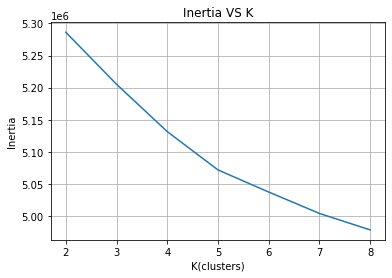

In [30]:
plt.plot(k, bow_inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K')
plt.grid()
plt.show()

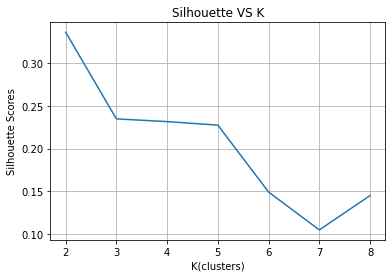

In [31]:
plt.plot(k, bow_silhouette_scores)
plt.xlabel('K(clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette VS K')
plt.grid()
plt.show()

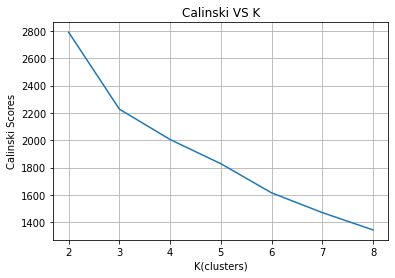

In [32]:
plt.plot(k, bow_calinski_score)
plt.xlabel('K(clusters)')
plt.ylabel('Calinski Scores')
plt.title('Calinski VS K')
plt.grid()
plt.show()

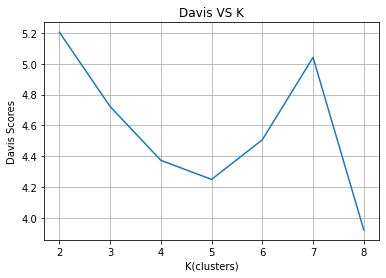

In [33]:
plt.plot(k, bow_davies_score)
plt.xlabel('K(clusters)')
plt.ylabel('Davis Scores')
plt.title('Davis VS K')
plt.grid()
plt.show()

Guardando le diverse metriche si nota che l'elbow è a k=5. Il coefficiente di Silhouette è massimo a k=2 (cosa che suggerisce che probabilmente non ci sono cluster ben definiti nel dataset, cosa per altro sostenuta anche dai valori dei coefficienti di Silhouette) ma i valori a k=3, k=4, k=5 sono tutti molto simili. Davies ha un minimo a 5, mentre per Calinski non è immediato individuare il numero corretto di cluster. Si procede, quindi, per k=5.

In [42]:
# Scelto il k ottimale, definisco il clustering

k_means_bow = KMeans(n_clusters=5, max_iter=20, n_init=10, random_state=123)
labels_bow = k_means_bow.fit_predict(x_clust_BOW)

In [43]:
# Performance modello di clustering

print(k_means_bow.inertia_)
print(sklearn.metrics.silhouette_score(x_clust_BOW, labels_bow))
print(sklearn.metrics.calinski_harabasz_score(x_clust_BOW, labels_bow))
print(sklearn.metrics.davies_bouldin_score(x_clust_BOW, labels_bow))

5067623.929560447
0.22334189463376858
1821.1156649641557
4.274095466734889


In [52]:
# Creo delle liste contenete gli elementi dei vari cluster, così da fare delle word cloud e analisi specifiche per cluster

bow_cluster1,bow_cluster2,bow_cluster3,bow_cluster4,bow_cluster5=[],[],[],[],[]
for i in range(k_means_bow.labels_.shape[0]):
    if k_means_bow.labels_[i] == 0:
        bow_cluster1.append(x_clust[i])
    elif k_means_bow.labels_[i] == 1:
        bow_cluster2.append(x_clust[i])
    elif k_means_bow.labels_[i] == 2:
        bow_cluster3.append(x_clust[i])
    elif k_means_bow.labels_[i] == 3:
        bow_cluster4.append(x_clust[i])
    else:
        bow_cluster5.append(x_clust[i])

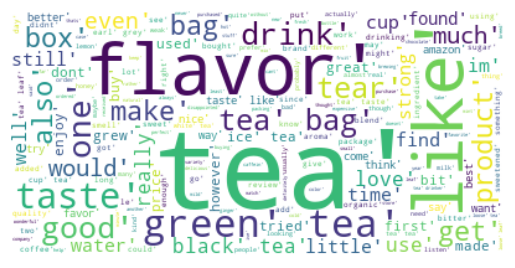

In [53]:
# Cluster 1
data=''
for i in bow_cluster1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

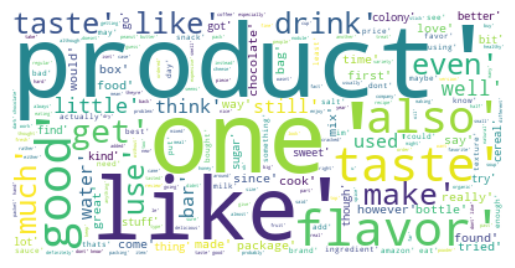

In [54]:
# Cluster 2
data=''
for i in bow_cluster2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

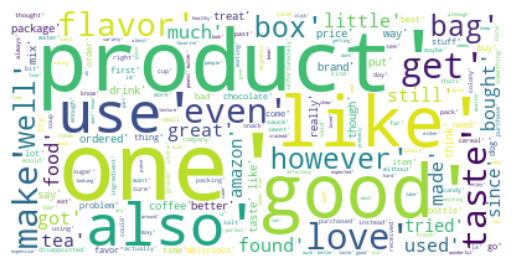

In [55]:
# Cluster 3
data=''
for i in bow_cluster3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

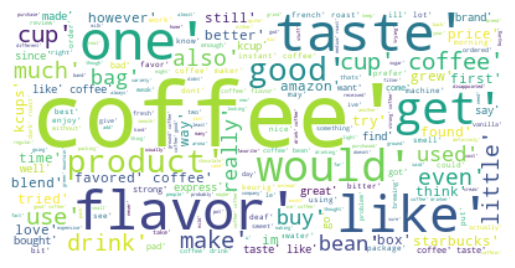

In [56]:
# Cluster 4
data=''
for i in bow_cluster4:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

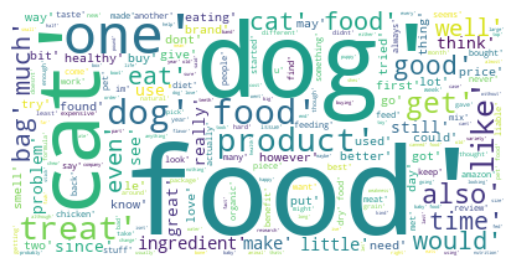

In [57]:
# Cluster 5
data=''
for i in bow_cluster5:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [58]:
cluster_list = [bow_cluster1, bow_cluster2, bow_cluster3, bow_cluster4, bow_cluster5]
print("Top 5 terms per cluster:")
for i in range(5):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: tea like taste flavor green
Cluster 2: like taste product one good
Cluster 3: taste product like good one
Cluster 4: coffee like taste cup flavor
Cluster 5: food dog cat like treat


## TF-IDF

In [21]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model = tv.fit(x_clust.astype(str))
x_clust_TFIDF = tv.transform(x_clust.astype(str))

In [22]:
tSVD_TFIDF = TruncatedSVD(n_components = 1000)
SVD_TFIDF = tSVD_TFIDF.fit(x_clust_TFIDF)
x_clust_TFIDF = tSVD_TFIDF.transform(x_clust_TFIDF)
print(SVD_TFIDF.explained_variance_ratio_.sum())

0.5639025791316314


In [ ]:
# Normalizzo i dati

# x_clust_TFIDF_norm = preprocessing.normalize(x_clust_TFIDF)

### K-means

In [21]:
k=[2,3,4,5,6,7,8]
tf_inertia=[]
tf_silhouette_scores = []
tf_calinski_score = []
tf_davies_score = []
for i in k:
    model=KMeans(n_clusters=i, random_state=123)
    labels = model.fit_predict(x_clust_TFIDF)
    tf_inertia.append(model.inertia_)
    tf_silhouette_scores.append(sklearn.metrics.silhouette_score(x_clust_TFIDF, labels))
    tf_calinski_score.append(sklearn.metrics.calinski_harabasz_score(x_clust_TFIDF, labels))
    tf_davies_score.append(sklearn.metrics.davies_bouldin_score(x_clust_TFIDF, labels))
    print('Iteration complete')

Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete


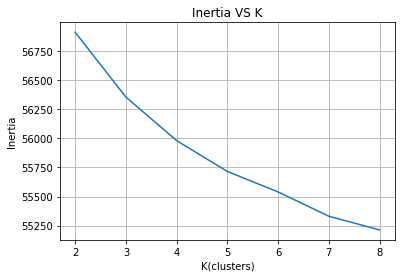

In [22]:
plt.plot(k, tf_inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K')
plt.grid()
plt.show()

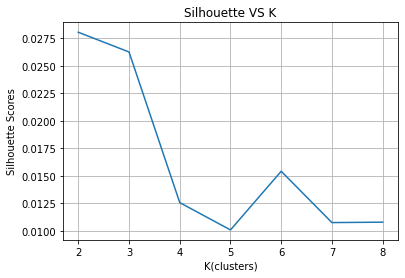

In [23]:
plt.plot(k, tf_silhouette_scores)
plt.xlabel('K(clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette VS K')
plt.grid()
plt.show()

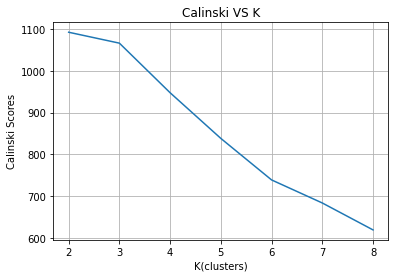

In [24]:
plt.plot(k, tf_calinski_score)
plt.xlabel('K(clusters)')
plt.ylabel('Calinski Scores')
plt.title('Calinski VS K')
plt.grid()
plt.show()

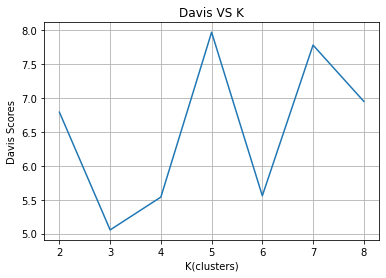

In [25]:
plt.plot(k, tf_davies_score)
plt.xlabel('K(clusters)')
plt.ylabel('Davis Scores')
plt.title('Davis VS K')
plt.grid()
plt.show()

In questo caso, per quanto l'elbow è a k=4, il coefficiente di Silhouette e lo score di Davies sono, rispettivamente, massimizzato e minimizzato in k=3. Anche Calinski in k=3 presenta un vertice più pronunciato rispetto agli altri k. In questo caso, quindi, si sceglie k=3.

In [23]:
# Scelto il k ottimale, definisco il clustering

k_means_tf = KMeans(n_clusters=3, max_iter=20, n_init=10, random_state=123)
labels_tf = k_means_tf.fit_predict(x_clust_TFIDF)

In [24]:
# Performance modello di clustering

print(k_means_tf.inertia_)
print(sklearn.metrics.silhouette_score(x_clust_TFIDF, labels_tf))
print(sklearn.metrics.calinski_harabasz_score(x_clust_TFIDF, labels_tf))
print(sklearn.metrics.davies_bouldin_score(x_clust_TFIDF, labels_tf))

56291.33733465323
0.026667480469992396
1071.4744518286413
5.084042169218741


In [25]:
tf_cluster1,tf_cluster2,tf_cluster3=[],[],[]
for i in range(k_means_tf.labels_.shape[0]):
    if k_means_tf.labels_[i] == 0:
        tf_cluster1.append(x_clust[i])
    elif k_means_tf.labels_[i] == 1:
        tf_cluster2.append(x_clust[i])
    else:
        tf_cluster3.append(x_clust[i])

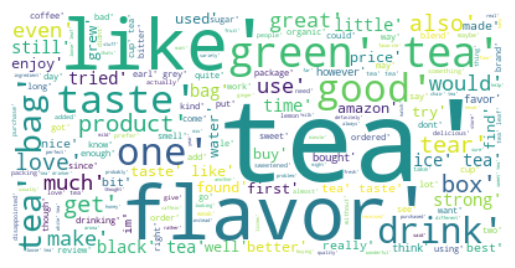

In [26]:
# Cluster 1
data=''
for i in tf_cluster1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

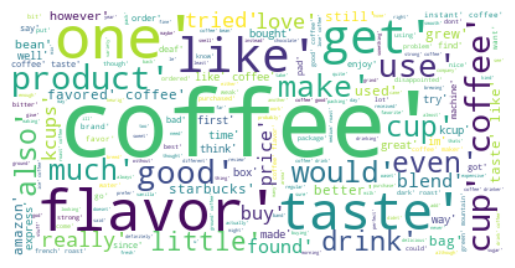

In [27]:
# Cluster 2
data=''
for i in tf_cluster2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

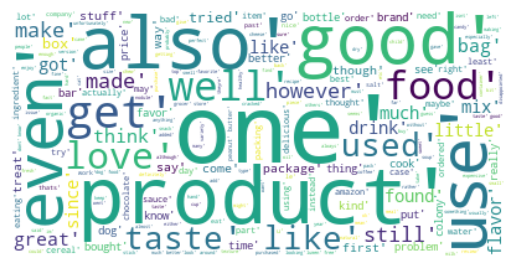

In [28]:
# Cluster 3
data=''
for i in tf_cluster3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
cluster_list = [tf_cluster1, tf_cluster2, tf_cluster3]
print("Top 5 terms per cluster:")
for i in range(3):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: tea taste like flavor good
Cluster 2: coffee like taste cup flavor
Cluster 3: like taste product good one


## W2V

In [30]:
w2v_model = gensim.models.Word2Vec(x_clust, vector_size=300, window=8, min_count=2)
words = set(w2v_model.wv.index_to_key)

In [31]:
x_clust_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in x_clust])

In [32]:
x_clust_avg = []
for v in x_clust_vect:
    if v.size:
        x_clust_avg.append(v.mean(axis=0))
    else:
        x_clust_avg.append(np.zeros(300, dtype=float))

In [ ]:
# Normalizzo i dati

# x_clust_avg_norm = preprocessing.normalize(x_clust_avg)

### K-means

In [14]:
k=[2,3,4,5,6,7,8]
w2v_inertia=[]
w2v_silhouette_scores = []
w2v_calinski_score = []
w2v_davies_score = []
for i in k:
    model=KMeans(n_clusters=i, random_state=123)
    labels = model.fit_predict(x_clust_avg)
    w2v_inertia.append(model.inertia_)
    w2v_silhouette_scores.append(sklearn.metrics.silhouette_score(x_clust_avg, labels))
    w2v_calinski_score.append(sklearn.metrics.calinski_harabasz_score(x_clust_avg, labels))
    w2v_davies_score.append(sklearn.metrics.davies_bouldin_score(x_clust_avg, labels))

    print('Iteration complete')

Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete
Iteration complete


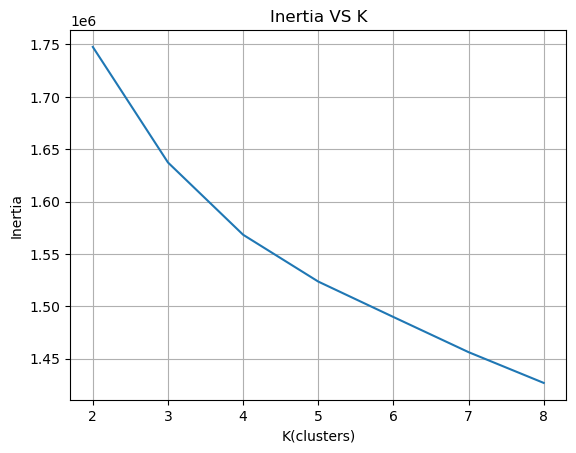

In [15]:
plt.plot(k, w2v_inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K')
plt.grid()
plt.show()

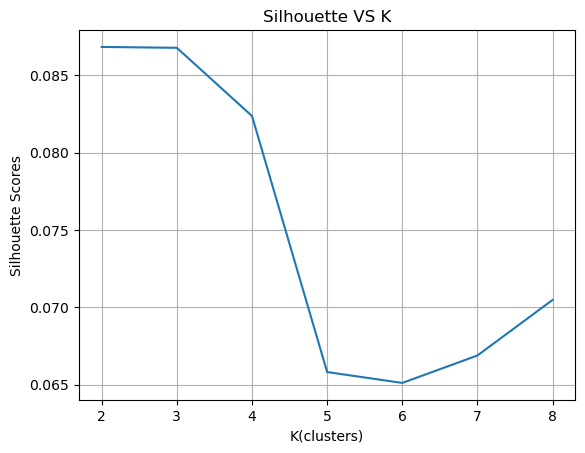

In [16]:
plt.plot(k, w2v_silhouette_scores)
plt.xlabel('K(clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette VS K')
plt.grid()
plt.show()

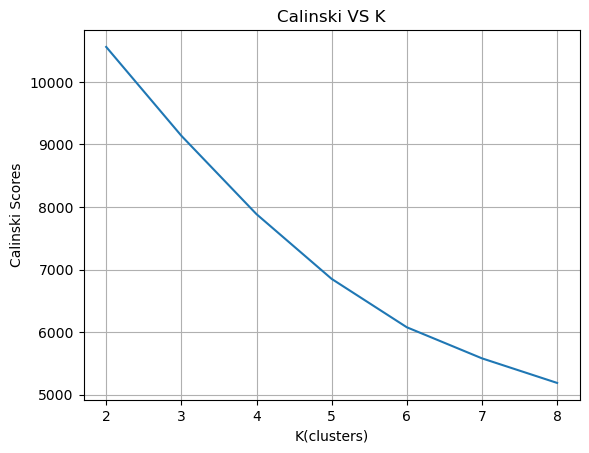

In [17]:
plt.plot(k, w2v_calinski_score)
plt.xlabel('K(clusters)')
plt.ylabel('Calinski Scores')
plt.title('Calinski VS K')
plt.grid()
plt.show()

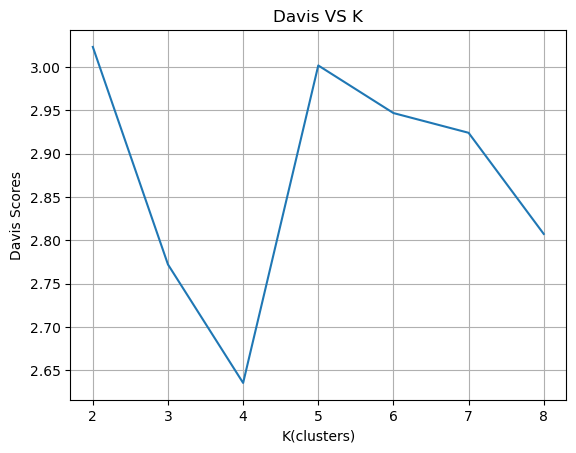

In [18]:
plt.plot(k, w2v_davies_score)
plt.xlabel('K(clusters)')
plt.ylabel('Davis Scores')
plt.title('Davis VS K')
plt.grid()
plt.show()

In questo caso a guidare la scelta sono specialmente Silhouette (i cui valori, comunque sono molto vicini a 0) e Davies che mostrano come, probabilmente, il numero ottimale di cluster sia k=4.

In [33]:
# Scelto il k ottimale, definisco il clustering

k_means_w2v = KMeans(n_clusters=4, max_iter=20, n_init=10, random_state=123)
labels_w2v = k_means_w2v.fit_predict(x_clust_avg)

In [34]:
# Performance modello di clustering

print(k_means_w2v.inertia_)
print(sklearn.metrics.silhouette_score(x_clust_avg, labels_w2v))
print(sklearn.metrics.calinski_harabasz_score(x_clust_avg, labels_w2v))
print(sklearn.metrics.davies_bouldin_score(x_clust_avg, labels_w2v))

1570412.6538235196
0.08086216646778188
7794.9993222409485
2.6544993776384276


In [35]:
w2v_cluster1,w2v_cluster2,w2v_cluster3,w2v_cluster4=[],[],[],[]
for i in range(k_means_w2v.labels_.shape[0]):
    if k_means_w2v.labels_[i] == 0:
        w2v_cluster1.append(x_clust[i])
    elif k_means_w2v.labels_[i] == 1:
        w2v_cluster2.append(x_clust[i])
    elif k_means_w2v.labels_[i] == 2:
        w2v_cluster3.append(x_clust[i])
    else:
        w2v_cluster4.append(x_clust[i])

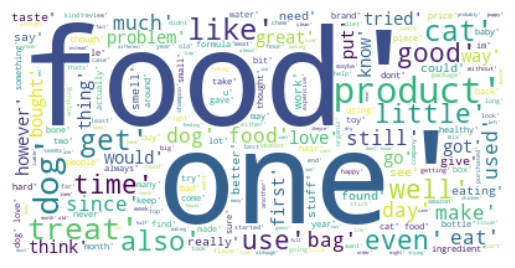

In [36]:
# Cluster 1
data=''
for i in w2v_cluster1:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

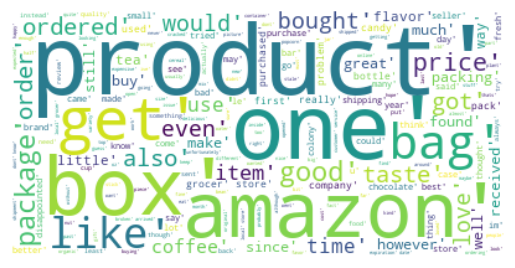

In [37]:
# Cluster 2
data=''
for i in w2v_cluster2:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

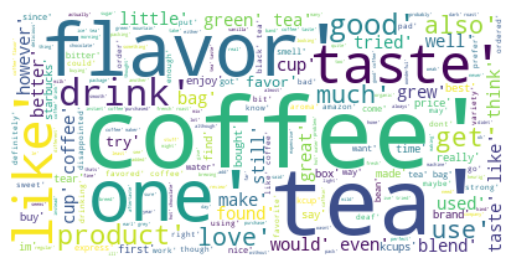

In [38]:
# Cluster 3
data=''
for i in w2v_cluster3:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

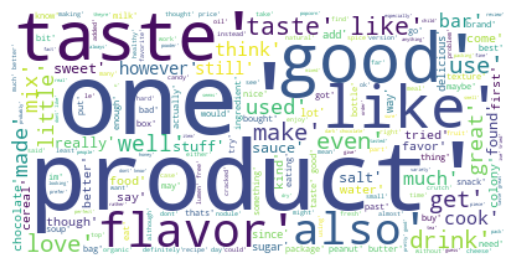

In [39]:
# Cluster 4
data=''
for i in w2v_cluster4:
    data+=str(i)

wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [40]:
cluster_list = [w2v_cluster1, w2v_cluster2, w2v_cluster3, w2v_cluster4]
print("Top 5 terms per cluster:")
for i in range(4):
    print("Cluster %d:" % (i+1), end='')
    flat_list = [item for sublist in cluster_list[i] for item in sublist]
    top5 = Counter(flat_list).most_common(5)
    for k in range(5):
        print(' %s' % top5[k][0], end='')
    print()

Top 5 terms per cluster:
Cluster 1: dog food like product cat
Cluster 2: product amazon box one price
Cluster 3: coffee tea taste like flavor
Cluster 4: taste like good flavor product


# Conclusioni

### K-means

- A seconda delle varie rappresentazioni, il numero ottimale di clusters nel caso di k-means risulta essere fra i 3 e i 5. In ogni caso, sia guardando le metriche valutative non supervisionate utilizzate, sia valutando qualitativamente le parole caratteristiche dei vari cluster, si nota come non esista una suddivisione netta dei dati in cluster ben definiti. In particolare i coefficienti di Silhouette vicini a 0 suggeriscono come i cluster tendano a sovrapporsi.

# Idee successive e utils

- Altri metodi di clustering (DBSCAN, Agglomerative clustering, ...)

- Link utili

Misure di performance: https://analyticsindiamag.com/a-tutorial-on-various-clustering-evaluation-metrics/